In [93]:
import json
from typing import Tuple, Union
from collections import deque
from matplotlib import pyplot as plt
import pyvis.network as net
import networkx as nx
# graphvis
# https://graphviz.org/download
from graphviz import Digraph
from IPython.display import display, Image, Markdown
EPS = 'eps'


In [94]:
# PART 1
class Validator:

    alphanumeric = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    dot = list('.')
    parentheses = list('()')
    brackets = list('[]')
    operators = list('|&*-?+')
    terminals = alphanumeric + dot + parentheses + brackets + operators

    S = '_S'
    A = '_A'
    B = '_B'
    E = '_E'
    R = '_R'
    G = '_G'
    T = '_T'
    C = '_C'

    rules = {
        S: [[S, '|', A], [A]],
        A: [[A, B], [B]],
        B: [[E, '*'], [E, '+'], [E, '?'], [E]],
        E: [['(', S, ')'], ['[', R, ']'], [T]],
        R: [[R, G], [G]],
        G: [[C, '-', C], [C]],
        T: [[C], ['.']],
        C: [[c] for c in alphanumeric]
    }

    rule2Index = {
        S: 0,
        A: 1,
        B: 2,
        E: 3,
        R: 4,
        G: 5,
        T: 6,
        C: 7
    }
    index2Rule = {v: k for k, v in rule2Index.items()}

    @staticmethod
    def is_terminal(c: str) -> bool:
        return c in Validator.terminals

    @staticmethod
    def all_terminals(rule: list[str]) -> bool:
        return all([Validator.is_terminal(c) for c in rule])

    def contains_terminals(rule: list[str]) -> bool:
        return any([Validator.is_terminal(c) for c in rule])

    @staticmethod
    def get_indices_inbound(c: str, l: int, r: int, symbolIndices: dict[str, list[int]]) -> list[int]:
        if c not in symbolIndices:
            return []
        return [i for i in symbolIndices[c] if l <= i <= r]

    @staticmethod
    def solve(left: int, right:int, idx: int, reg: str, symbolIndices: dict[str, list[int]], mem) -> bool:
        if mem[left][right][idx] != -1:
            return mem[left][right][idx]
        if left > right:
            mem[left][right][idx] = False
            return mem[left][right][idx]
        rule = Validator.index2Rule[idx]
        for r in Validator.rules[rule]:
            # case1 r contains terminals only
            # base case
            if Validator.all_terminals(r):
                if reg[left:right+1] == ''.join(r):
                    mem[left][right][idx]= True
                    return mem[left][right][idx]
            # case2 r contains terminals
            elif Validator.contains_terminals(r):
                # brackets
                if Validator.is_terminal(r[0]) and Validator.is_terminal(r[-1]):
                    terminal_indices_left = Validator.get_indices_inbound(r[0], left, right, symbolIndices)
                    terminal_indices_right = Validator.get_indices_inbound(r[-1], left, right, symbolIndices)
                    if len(terminal_indices_left) > 0 and len(terminal_indices_right)>0 and left == terminal_indices_left[0] and right == terminal_indices_right[-1] and Validator.solve(left+1, right-1, Validator.rule2Index[r[1]],reg,symbolIndices,mem):
                        mem[left][right][idx]= True
                        return mem[left][right][idx]
                else:
                    # r[1] is a terminal
                    terminal_indices = Validator.get_indices_inbound(r[1], left, right, symbolIndices)
                    for i in terminal_indices:
                        if Validator.solve(left, i-1, Validator.rule2Index[r[0]],reg,symbolIndices,mem):
                            if len(r) == 2:
                                if i == right:
                                    mem[left][right][idx]=True
                                    return mem[left][right][idx]
                            elif Validator.solve(i+1, right, Validator.rule2Index[r[2]],reg,symbolIndices,mem):
                                mem[left][right][idx]=True
                                return mem[left][right][idx]
            # case3 r contains non-terminals only
            else:
                # match all string
                if len(r) == 1:
                    if Validator.solve(left, right, Validator.rule2Index[r[0]],reg,symbolIndices,mem):
                        mem[left][right][idx] =True
                        return mem[left][right][idx]
                else:
                # match till right-1
                    for i in range(left, right):
                        if Validator.solve(left, i, Validator.rule2Index[r[0]],reg,symbolIndices,mem) and Validator.solve(i+1, right, Validator.rule2Index[r[1]],reg,symbolIndices,mem):
                            mem[left][right][idx]=True
                            return mem[left][right][idx]
        mem[left][right][idx]= False
        return False
    @staticmethod
    def fill_symbol_indices(reg: str) -> dict[str, list[int]]:
        symbolIndices = {}
        for i,c in enumerate(reg):
            if c not in symbolIndices:
                symbolIndices[c] = [i]
            else:
                symbolIndices[c].append(i)
        return symbolIndices
    
    @staticmethod
    def validate(reg: str) -> bool:
        symbolIndices = Validator.fill_symbol_indices(reg)
        mem = [[[-1 for _ in range(len(Validator.rules))] for _ in range(len(reg))] for _ in range(len(reg))]
        return Validator.solve(0, len(reg)-1, Validator.rule2Index[Validator.S], reg, symbolIndices, mem)


class Operator:
    @staticmethod
    def precedence(op):
        if op == '|':
            return 2
        elif op == '&':
            return 1
        elif op == '-':
            return 0
        elif op == '*':
            return 0
        elif op == '+':
            return 0
        elif op == '?':
            return 0
        else:
            # brackets
            return None


class State:
    count = 0

    def __init__(self, is_accepting: bool = False, transitions: list["Transition"] = []):
        self.is_terminating = is_accepting
        self.transitions: list[Transition] = []
        self.id = State.count
        State.count += 1

    def to_json(self):
        transitions_dict = {}
        for t in self.transitions:
            if t.input in transitions_dict:
                if type(transitions_dict[t.input]) == list:
                    transitions_dict[t.input].append(f'S{t.to.id}')
                else:
                    transitions_dict[t.input] = [
                        transitions_dict[t.input], f'S{t.to.id}']
            else:
                transitions_dict[t.input] = f'S{t.to.id}'

        return {
            f'S{self.id}': {
                "isTerminatingState": self.is_terminating,
                **transitions_dict
            }
        }


class Transition:
    def __init__(self, input: str, to: State):
        self.to = to
        self.input = input


unary_operators = ['*', '+', '?']
binary_operators = ['|', '&', '-']
opening_brackets = ['(']
closing_brackets = [')']


class Preprocessor:
    @staticmethod
    def preprocess(text):
        ret = ""
        sz = len(text)
        square_brackets = 0
        i = 0
        while i < sz-1:
            ret += text[i]
            square_brackets += (text[i] == '[')
            square_brackets -= (text[i] == ']')
            if square_brackets==0 and not (text[i] in binary_operators or text[i] in opening_brackets or text[i+1] in binary_operators or text[i+1] in closing_brackets or text[i+1] in unary_operators):
                ret += '&'
            i += 1
        ret += text[sz-1]
        return ret


class FA:
    def __init__(self) -> None:
        self.start = None
        self.end = None

    def add_operand_FA(self, operand: str, states: list[State]):
        self.start = State()
        self.end = State()
        states.append(self.start)
        states.append(self.end)
        if operand == '.':
            # for all digits and alphabets
            for i in range(26):
                if i < 10:
                    transition = Transition(chr(ord('0')+i), self.end)
                    self.start.transitions.append(transition)
                transition = Transition(chr(ord('a')+i), self.end)
                self.start.transitions.append(transition)
                transition = Transition(chr(ord('A')+i), self.end)
                self.start.transitions.append(transition)
        else:
            transition = Transition(operand, self.end)
            self.start.transitions.append(transition)

    def add_or_FA(self, operands: list["FA"], states: list[State]):
        self.start = State()
        self.end = State()
        states.append(self.start)
        states.append(self.end)
        self.start.transitions.append(Transition("eps", operands[0].start))
        self.start.transitions.append(Transition("eps", operands[1].start))
        operands[0].end.transitions.append(Transition("eps", self.end))
        operands[1].end.transitions.append(Transition("eps", self.end))

    def add_and_FA(self, operands: list["FA"], states: list[State]):
        self.start = operands[0].start
        self.end = operands[1].end
        operands[0].end.transitions.append(
            Transition("eps", operands[1].start))

    def add_square_bracket_FA(self, ranges: list[list[str]], states: list[State]):
        self.start = State()
        self.end = State()
        states.append(self.start)
        states.append(self.end)
        for operands in ranges:
            if len(operands) == 2:
                for i in range(ord(operands[0]), ord(operands[1])+1):
                    transition = Transition(chr(i), self.end)
                    self.start.transitions.append(transition)
            else:
                transition = Transition(operands[0], self.end)
                self.start.transitions.append(transition)

    def add_asterisk_FA(self, operand: "FA", states: list[State]):
        self.start = State()
        self.end = State()
        states.append(self.start)
        states.append(self.end)
        self.start.transitions.append(Transition("eps", self.end))
        self.start.transitions.append(Transition("eps", operand.start))
        operand.end.transitions.append(Transition("eps", self.end))
        operand.end.transitions.append(Transition("eps", self.start))

    def add_plus_FA(self, operand: "FA", states: list[State]):
        self.start = State()
        self.end = State()
        states.append(self.start)
        states.append(self.end)
        self.start.transitions.append(Transition("eps", operand.start))
        operand.end.transitions.append(Transition("eps", self.end))
        operand.end.transitions.append(Transition("eps", self.start))

    def add_question_mark_FA(self, operand: "FA", states: list[State]):
        self.start = State()
        self.end = State()
        states.append(self.start)
        states.append(self.end)
        self.start.transitions.append(Transition("eps", self.end))
        self.start.transitions.append(Transition("eps", operand.start))
        operand.end.transitions.append(Transition("eps", self.end))


class RegParser:
    def __init__(self, text):
        if not Validator.validate(text):
            raise Exception("Invalid Regular Expression")
        self.text = Preprocessor.preprocess(text)
        print(self.text)
        self.build()
        print(self.q)
        self.states: list[State] = []

    def build(self):
        q = []
        text = self.text
        st = []
        sz = len(text)
        i = 0
        while i<sz:
            # case 1: alphabet, digit, dot
            if text[i].isalpha() or text[i].isdigit() or text[i] == '.' or text[i] == '-':
                q.append(text[i])
            # case 2: operators
            elif Operator.precedence(text[i]) is not None:
                while len(st) > 0 and Operator.precedence(st[-1]) is not None and Operator.precedence(st[-1]) <= Operator.precedence(text[i]):
                    q.append(st.pop())
                st.append(text[i])
            # case 3: opening brackets
            elif text[i] in opening_brackets:
                st.append(text[i])
            # case 4: closing brackets
            elif text[i] in closing_brackets:
                opening = '('
                while len(st) > 0 and st[-1] != opening:
                    q.append(st.pop())
                if len(st) == 0:
                    raise Exception("Invalid Regular Expression")
                st.pop()
            elif text[i] == '[':
                while i<sz and text[i] != ']':
                    q.append(text[i])
                    i += 1
                q.append(text[i])
            i+=1
        while (len(st) > 0):
            if (st[-1] in opening_brackets):
                raise Exception("Invalid Regular Expression")
            else:
                q.append(st[-1])
            st.pop()
        self.q = q

    @staticmethod
    def is_operand(c):
        return c.isalpha() or c.isdigit() or c == '.'

    def parse(self):
        sz = len(self.q)
        st: list[FA] = []
        i = 0
        while i < sz:
            fa = FA()
            if not RegParser.is_operand(self.q[i]):
                if self.q[i] == '|':
                    fa.add_or_FA([st[-2], st[-1]], self.states)
                    st.pop()
                    st.pop()
                elif self.q[i] == '&':
                    fa.add_and_FA([st[-2], st[-1]], self.states)
                    st.pop()
                    st.pop()
                elif self.q[i] == '*':
                    fa.add_asterisk_FA(st[-1], self.states)
                    st.pop()
                elif self.q[i] == '+':
                    fa.add_plus_FA(st[-1], self.states)
                    st.pop()
                elif self.q[i] == '?':
                    fa.add_question_mark_FA(st[-1], self.states)
                    st.pop()
                elif self.q[i] == '[':
                    i+=1
                    substr = ''
                    while i<sz and self.q[i] != ']':
                        substr += self.q[i]
                        i += 1
                    ranges = []
                    j = 0
                    while j < len(substr):
                        if j+2 < len(substr) and substr[j+1] == '-':
                            ranges.append([substr[j], substr[j+2]])
                            j += 3
                        else:
                            ranges.append([substr[j]])
                            j += 1
                    fa.add_square_bracket_FA(ranges, self.states)
            else:
                fa.add_operand_FA(self.q[i], self.states)
            st.append(fa)
            i += 1
        st[-1].end.is_terminating = True
        ret = {
            "startingState": f'S{st[-1].start.id}',
        }
        for s in self.states:
            ret.update(s.to_json())
        return ret


## Part 2 

In [95]:
class State_m:
    def __init__(self, id: str, is_terminating_state: bool, transitions: dict[str, list[str]]):
        self.id = id
        self.is_terminating_state = is_terminating_state
        self.transitions = transitions

    def have_transition(self, input: str) -> bool:
        return input in self.transitions.keys()



class AutomataMachine:
    def __init__(self, name: str = 'NFA'):
        self.name = name
        self.starting_state: str = None
        self.states = {}

    def init_from_file(self, json_file):
        self.states = self.load_json(json_file)
        return self

    def init_from_dict(self, states: dict[str, bool], starting_state: str, transitions: dict[str, dict[str, list[str]]]):
        self.starting_state = starting_state
        for state, is_terminal in states.items():
            self.add_state(state, is_terminal, transitions[state])

    def load_json(self, json_file) -> dict[str, State_m]:
        with open(json_file, 'r') as file:
            data = json.load(file)
        # print(data)
        self.starting_state: str = data['startingState']
        data.pop('startingState')

        states = {}
        for key, value in data.items():
            # v can be a list of states or a single state
            transitions = {k: [v] if not isinstance(
                v, list) else v for k, v in value.items() if k != 'isTerminatingState'}
            states[key] = State_m(
                key, value['isTerminatingState'], transitions)
        return states

    def get_starting_state(self):
        return self.starting_state

    def get_state(self, state):
        return self.states[state]

    def is_terminating_state(self, state):
        return self.states[state].is_terminating_state

    def get_next_state(self, state, input) -> Union[list[str], None]:
        """
        Returns the next state given the current state and input 
        and `None` if the transition is not possible
        """
        if input not in self.states[state].transitions.keys():
            return None
        nxt_state = self.states[state].transitions[input]
        return nxt_state

    def add_state(self, state: str, is_terminating_state: bool, transitions: dict[str, list[str]]):
        self.states[state] = State_m(state, is_terminating_state, transitions)

    def add_transition(self, state: str, input: str, next_state: str):
        if state not in self.states.keys():
            self.add_state(state, False, {})
        if input not in self.states[state].transitions.keys():
            self.states[state].transitions[input] = []

        self.states[state].transitions[input].append(next_state)

    def save_to_json(self, file):
        with open(file, 'w') as f:
            data = {'startingState': self.starting_state}
            for k, v in self.states.items():
                data[k] = {'isTerminatingState': v.is_terminating_state}
                for kk, vv in v.transitions.items():
                    data[k][kk] = vv[0] if len(vv) == 1 else vv

                data[k] = dict(sorted(data[k].items(),))

            json.dump(data, f, indent=4)

    def draw(self):
        G = nx.MultiDiGraph()
        merged_edges = {}
        for state in self.states.values():
            # https://stackoverflow.com/questions/74082881/adding-icon-for-node-shape-using-networkx-and-pyvis-python
            G.add_node(
                state.id, color='gray' if not state.id == self.starting_state else 'orange', shape='diamond' if state.is_terminating_state else 'circle', size=10, font={'size': 8}
            )

            # merge common edges like if 2 edges like (s1,s2,"a") and (s1,s2,"b") are present, merge them to (s1,s2,"a,b")
            for k, v in state.transitions.items():
                for dest_state in v:
                    edge = (state.id, dest_state, k)
                    if edge[:2] in merged_edges.keys():
                        merged_edges[edge[:2]].append(edge[2])
                    else:
                        merged_edges[edge[:2]] = [edge[2]]

            # finally add the merged edges to the graph
            for k, v in merged_edges.items():
                G.add_edge(k[0], k[1], label=','.join(
                    v), color='gray' if k[1] != EPS else 'red')

        nt = net.Network(notebook=True, cdn_resources='remote', directed=True)
        nt.show_buttons(filter_=['physics'])
        nt.set_edge_smooth('dynamic')
        nt.from_nx(G)
        nt.repulsion(spring_strength=0.02)
        nt.toggle_physics(True)
        nt.show(f'./out_imgs/{self.name}_FSM.html')

        # draw a graphviz graph

        dot = Digraph()
        dot.attr(rankdir='LR')  
        # Set global node attributes.
        dot.attr('node',  color='darkgrey', width='1.2', height='1.2', fixedsize='true')
        # Create an invisible node for pointing to starting states.
        dot.node('start', shape='none', label='', width='0', height='0')

        for state in self.states.values():
            # Determine node shape based on whether it is a terminating state.
            node_shape = 'doublecircle' if state.is_terminating_state else 'circle'
            dot.node(state.id, label=state.id, shape=node_shape)
            # If the state is a starting state, add an invisible edge from the start node to this state.
            if state.id == self.starting_state:
                dot.edge('start', state.id, style='invisible')


        # add edges from merged_edges
        for k, v in merged_edges.items():
            dot.edge(k[0], k[1], label=','.join(v))
            

        dot.render(f'out_imgs/{self.name}_FSM', format='png', cleanup=True)
        return Image(f'out_imgs/{self.name}_FSM.png')
        

        


## NFA TO DFA


In [96]:

class dfa_generator:

    def __init__(self, json_file):
        self.nfa_sm = AutomataMachine().init_from_file(json_file)

    def get_states_group_id(self, states: set[str]):
        """
        if a group contains S0, S3 and S4, the id will be S0_S3_S4
        """
        l = list(states)
        l.sort()
        return '_'.join(l)

    def get_closure(self, state: State_m) -> Tuple[set[str], set[str], bool]:
        """
        Returns the epsilon closure of a state
        2 sets are returned, one for the states and the other for the combined Transitions
        """
        ret_states = set()
        ret_transitions = set()
        q = deque()
        q.append(state)
        is_terminating = False
        while q:
            curr_state = q.popleft()
            ret_states.add(curr_state.id)
            is_terminating = is_terminating or curr_state.is_terminating_state
            # the transitions of the group is the union of all transitions from each state
            ret_transitions = ret_transitions.union(
                set(curr_state.transitions.keys()))

            if EPS in curr_state.transitions.keys():
                for s in curr_state.transitions[EPS]:
                    if s not in ret_states:
                        q.append(self.nfa_sm.get_state(s))

        return ret_states, ret_transitions, is_terminating

    def convert_to_dfa(self):
        """
        Converts an NFA to a DFA
        """
        start_state = self.nfa_sm.get_starting_state()
        start_closure_states, start_closure_T, is_terminal = self.get_closure(
            self.nfa_sm.get_state(start_state))

        states: dict[str, bool] = {}
        # {state: {input: [next_states]}}
        transitions: dict[str, dict[str, list[str]]] = {}
        q = deque()
        q.append((start_closure_states, start_closure_T, is_terminal))

        while q:
            curr_group_states, curr_group_Ts, is_terminal = q.popleft()
            curr_id = self.get_states_group_id(curr_group_states)
            states[curr_id] = is_terminal
            transitions[curr_id] = {}
            for t in curr_group_Ts:
                if t == EPS:
                    continue
                next_group_states = set()
                next_group_Ts = set()
                next_is_terminal = False

                for state in curr_group_states:
                    s = self.nfa_sm.get_state(state)
                    if s.have_transition(t):
                        # reachable from the current group
                        next_states = s.transitions[t]
                        for ns in next_states:
                            se, te, it = self.get_closure(
                                self.nfa_sm.get_state(ns))
                            next_group_states = next_group_states.union(se)
                            next_group_Ts = next_group_Ts.union(te)
                            next_is_terminal = next_is_terminal or it

                transitions[curr_id][t] = [
                    self.get_states_group_id(next_group_states)]

                if self.get_states_group_id(next_group_states) not in states.keys():
                    q.append((next_group_states, next_group_Ts, next_is_terminal))

        new_dfa = AutomataMachine(name='DFA')
        new_dfa.init_from_dict(states, self.get_states_group_id(
            start_closure_states), transitions)
        return new_dfa

## DFA MINIMIZATION

In [97]:
class DFA_Minimizer:

    def __init__(self, dfa: AutomataMachine):
        self.dfa = dfa
        # we begin by splitting the states into 2 groups, the terminating states and the non-terminating states
        self.list_of_groups: list[set] = [
            {state for state in dfa.states.keys(
            ) if not dfa.is_terminating_state(state)},
            {state for state in dfa.states.keys() if dfa.is_terminating_state(state)}
        ]

    def get_group(self, state: str, list_of_groups: list[set] = None) -> int:
        # if not a local list of groups then use the global one
        if not list_of_groups:
            list_of_groups = self.list_of_groups

        for i, g in enumerate(list_of_groups):
            if state in g:
                return i

        return -1

    def minimize(self):
        # we will keep merging the groups until no more merges can be done
        while True:
            new_groups = []
            for group in self.list_of_groups:
                # if the group has only 1 element, we can't split it any further
                if len(group) == 1:
                    new_groups.append(group)
                    continue

                # we will split the group into subgroups
                subgroups = {}
                for state in group:
                    # get the transitions of the state
                    transitions = self.dfa.states[state].transitions

                    state_transitions_to_go_groups = tuple(
                        sorted([(k, self.get_group(v[0])) for k, v in transitions.items()]))  # this is like (a, 0), (b, 1) etc (input, group_id)
                    if state_transitions_to_go_groups not in subgroups.keys():
                        subgroups[state_transitions_to_go_groups] = set()

                    subgroups[state_transitions_to_go_groups].add(state)

                # add the subgroups to the new groups
                new_groups.extend(subgroups.values())

            # if the new groups are the same as the old groups, we can't split anymore
            if new_groups == self.list_of_groups:
                break
            self.list_of_groups = new_groups

    def reconstruct_dfa(self) -> AutomataMachine:
        # create a new dfa with the new groups
        # get copy of the old dfa
        old_states = self.dfa.states.copy()
        old_starting_state = self.dfa.get_starting_state()
        new_starting_state = None
        new_dfa = AutomataMachine(name='Minimized_DFA')
        for i, group in enumerate(self.list_of_groups):
            # we take the first node as a represintive for the group
            # make it take all the transitions of all the states in the group
            # mark as starting state if the old starting state is in the group
            is_starting = old_starting_state in group
            if is_starting:
                new_starting_state = str(i)
            new_transitions = {}
            is_terminal = False
            for state in group:
                s = old_states[state]
                is_terminal = is_terminal or s.is_terminating_state
                for k, v in s.transitions.items():
                    # transitions should be one-to-one as we have a dfa here
                    new_transitions[k] = [str(self.get_group(v[0]))]

            # add the new state to the new dfa
            new_dfa.add_state(str(i), is_terminal, new_transitions)
        new_dfa.starting_state = new_starting_state

        return new_dfa


[A-Za-z]+&[0-9]*
['[', 'A', '-', 'Z', 'a', '-', 'z', ']', '+', '[', '0', '-', '9', ']', '*', '&']
./out_imgs/NFA_FSM.html


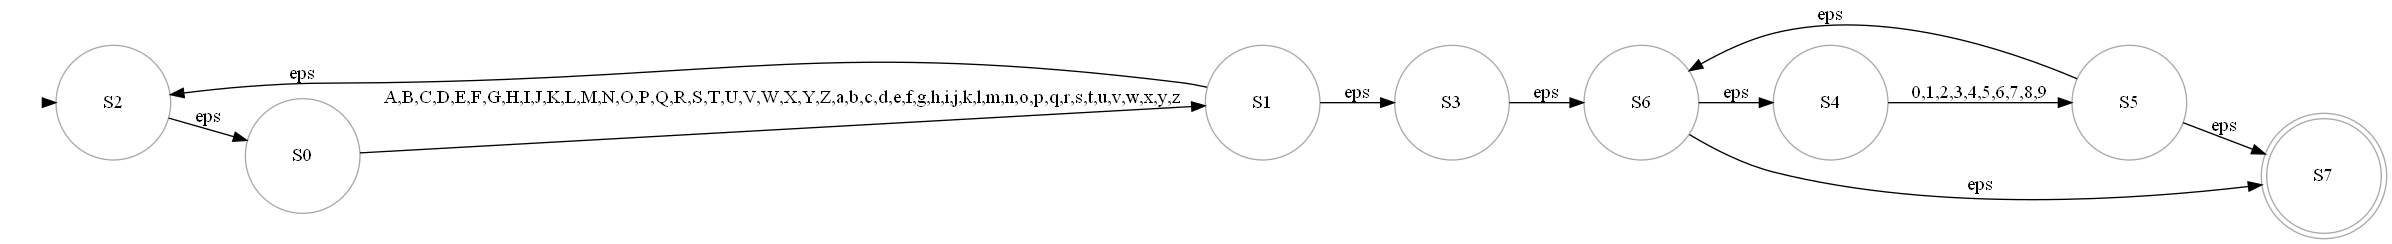

S0_S2 -> False -> {'G': ['S0_S1_S2_S3_S4_S6_S7'], 'U': ['S0_S1_S2_S3_S4_S6_S7'], 'h': ['S0_S1_S2_S3_S4_S6_S7'], 'A': ['S0_S1_S2_S3_S4_S6_S7'], 'E': ['S0_S1_S2_S3_S4_S6_S7'], 'O': ['S0_S1_S2_S3_S4_S6_S7'], 'p': ['S0_S1_S2_S3_S4_S6_S7'], 'u': ['S0_S1_S2_S3_S4_S6_S7'], 'F': ['S0_S1_S2_S3_S4_S6_S7'], 'L': ['S0_S1_S2_S3_S4_S6_S7'], 'H': ['S0_S1_S2_S3_S4_S6_S7'], 'n': ['S0_S1_S2_S3_S4_S6_S7'], 'Q': ['S0_S1_S2_S3_S4_S6_S7'], 'a': ['S0_S1_S2_S3_S4_S6_S7'], 'd': ['S0_S1_S2_S3_S4_S6_S7'], 'K': ['S0_S1_S2_S3_S4_S6_S7'], 'T': ['S0_S1_S2_S3_S4_S6_S7'], 'Z': ['S0_S1_S2_S3_S4_S6_S7'], 'v': ['S0_S1_S2_S3_S4_S6_S7'], 'y': ['S0_S1_S2_S3_S4_S6_S7'], 'w': ['S0_S1_S2_S3_S4_S6_S7'], 'x': ['S0_S1_S2_S3_S4_S6_S7'], 'g': ['S0_S1_S2_S3_S4_S6_S7'], 'R': ['S0_S1_S2_S3_S4_S6_S7'], 'P': ['S0_S1_S2_S3_S4_S6_S7'], 'D': ['S0_S1_S2_S3_S4_S6_S7'], 'J': ['S0_S1_S2_S3_S4_S6_S7'], 'b': ['S0_S1_S2_S3_S4_S6_S7'], 'V': ['S0_S1_S2_S3_S4_S6_S7'], 'k': ['S0_S1_S2_S3_S4_S6_S7'], 'Y': ['S0_S1_S2_S3_S4_S6_S7'], 'z': ['S0_S1_S2_S3_S

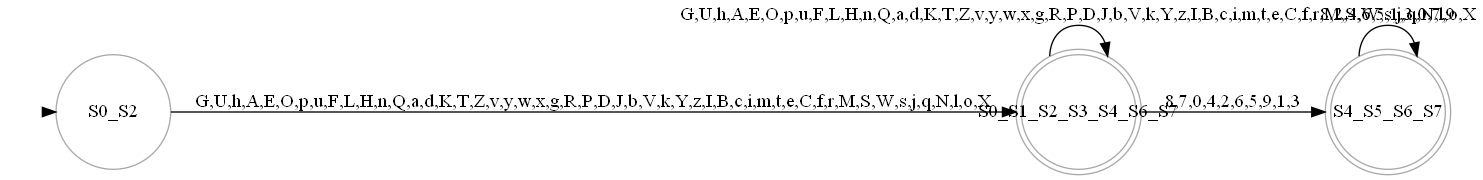

./out_imgs/Minimized_DFA_FSM.html


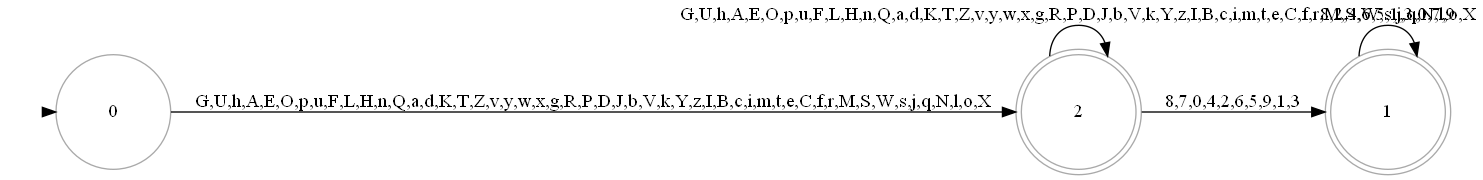

In [98]:
def print_states(fsm):
    for k, v in fsm.states.items():
        print(f'{k} -> {v.is_terminating_state} -> {v.transitions}')

if __name__ == "__main__":
    reg = "[a-c]*b"#input("Enter Regular Expression: ")
    ans = RegParser("[A-Za-z]+[0-9]*").parse()
    with open("output.json", "w") as f:
        f.write(json.dumps(ans, indent=4))
        
    state_machine = AutomataMachine().init_from_file('output.json')
    # display(Markdown(f"# asdas"))
    display(state_machine.draw())
    dfa_gen = dfa_generator('output.json')
    # aa = dfa.get_closure(dfa.nfa_sm.get_state('S2'))
    new_dfa = dfa_gen.convert_to_dfa()
    print_states(new_dfa)
    display(new_dfa.draw())
    new_dfa.save_to_json('dfa.json')
    minimizer = DFA_Minimizer(new_dfa)
    minimizer.minimize()
    minized_dfa = minimizer.reconstruct_dfa()
    display(minized_dfa.draw())

